# JC chain device simulation with large L

* In this notebook we will do some simulations for the Jaines-Cummings chain for system sizes attainable in lab $(L\sim 80)$

* We will look at the $XX$ and $ZZ$ correaltion functions and entanglement entropy for various choices of the time parameter $\theta$


In [3]:
import numpy as np
import torch
from torch.autograd import Variable
import torch.optim as optim
from scipy.stats import unitary_group
import matplotlib.pyplot as plt
from quimb import *
from quimb.tensor import *
import sympy as sym

import scipy as sp
from scipy import linalg

from JC_functions import *

## Lets look at the hopping probabilities for 8 different values of $\theta$ 

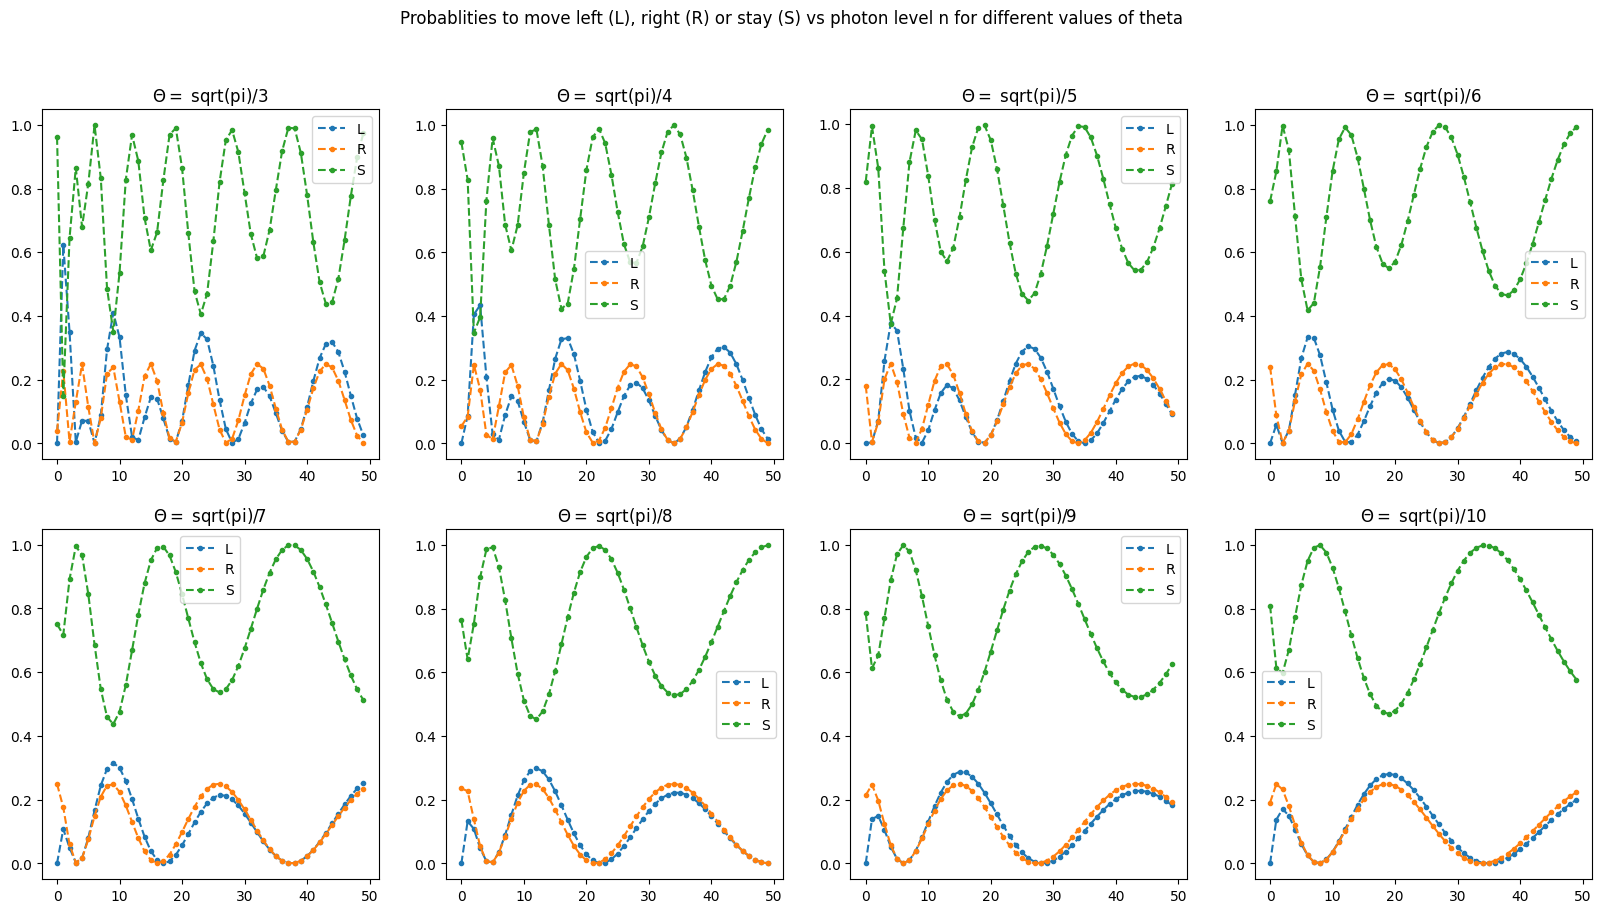

In [11]:
N= 50
theta_list = [3*np.sqrt(np.pi)/(i) for i in range(3,12)]
theta_sym_list = [sym.symbols(f'{sym.sqrt(sym.pi)/i}') for i in range(3,12)]


fig, axs = plt.subplots(2,4, figsize = (20,10))
for i in range(4):
    for j in range(2):
        L, S, R = [[], [],[]]
        for n in range(N):
            P = Hop_prob(n,theta_list[4*j + i])
            L.append(P[0])
            S.append(P[1])
            R.append(P[2])

        axs[j,i].plot(L, '--.', label = 'L')
        axs[j,i].plot(R, '--.', label = 'R')
        axs[j,i].plot(S, '--.', label = 'S')
        axs[j,i].set_title(f'$\Theta =$ {theta_sym_list[4*j+i]}')
        axs[j,i].legend()

fig.suptitle('Probablities to move left (L), right (R) or stay (S) vs photon level n for different values of theta')
plt.show()


# Now lets define some matrix product states:

## MPS for the choice of $\theta$ above

In [5]:
import time
t0 = time.time()

MPS_dictionary_theta = {}
chi = max(int(N/10), 20)

for theta in theta_list[:2]:
    A_JC = MPS_JC_2site(chi,theta)
    BL = np.zeros((2, chi, chi))
    BL[0,0,0] = 1

    MPS_list = [A_JC for i in range(N)]
    MPS_list.insert(0, BL)
    MPS_list.append(BL)

    JC_MPS = MatrixProductState(MPS_list, shape = 'plr')
    JC_MPS.cyclic = False
    JC_MPS.normalize()

    MPS_dictionary_theta[theta] = JC_MPS
    print(f'finished theta at time {time.time()-t0}')

finished theta at time 44.10819101333618
finished theta at time 83.59121823310852


## MPS for Motzkin chain (for comparison)

In [6]:
pL, pR = [.2,.2]
A_Motz = MPS_Motzkin(chi, pL,pR)
BL = np.zeros((2, chi, chi))
BL[0,0,0] = 1

MPS_list1 = [A_Motz for i in range(N)]
MPS_list1.insert(0, BL)
MPS_list1.append(BL)

Motz_MPS = MatrixProductState(MPS_list1, shape = 'plr')
Motz_MPS.cyclic = False
Motz_MPS.normalize()


0.031534238065418455

# Now lets plot correlation functions for the MPS above

In [7]:
Z_A, Z_B = [np.kron(pauli('Z'), np.eye(2)), np.kron(np.eye(2),pauli('Z'))]
X_A, X_B = [np.kron(pauli('X'), np.eye(2)), np.kron(np.eye(2),pauli('X'))]

Zspin1 = pauli('Z', dim=3)
Xspin1 = pauli('X', dim=3)


In [9]:
import time
t0 =time.time()

for x in [10,50, 100]:
    print(np.real(MPS_dictionary_theta[theta_list[0]].correlation(Z_A+Z_B, 2,x)))
    print(f'this took {time.time()-t0}')

-0.026372354659644166
this took 125.69768595695496
-0.002318918391188399
this took 249.95182299613953
-0.0005477057483095804
this took 383.7791979312897


## ZZ and XX correlation function matrix for each theta:

## Grid of XX and ZZ correlation functions 


In [8]:
t0 = time.time()

x_list = np.arange(2,N, 4)
x0 = 2

ZZ_data_JC, XX_data_JC = [{}, {}]
ZZ_data_motz, XX_data_motz = [np.zeros(len(x_list)), np.zeros(len(x_list))]

for theta in theta_list[0:2]:
    ZZ, XX = [np.zeros(len(x_list)), np.zeros(len(x_list))]
    for i, x in enumerate(x_list):
        ZZ[i] = np.real(MPS_dictionary_theta[theta].correlation(Z_A+Z_B, x0,x))
        XX[i] = np.real(MPS_dictionary_theta[theta].correlation(X_A+X_B, x0,x))
        if i % int(len(x_list)/5) == 0:
            print(f'just finished position {i}')
            print('==========================')

    print(f'finished theta at time {time.time()-t0}')
    ZZ_data_JC[theta] = ZZ
    XX_data_JC[theta] = XX

for i in range(len(x_list)):
    ZZ_data_motz[i] = np.real(Motz_MPS.correlation(Zspin1, x0,x_list[i]))
    XX_data_motz[i] = np.real(Motz_MPS.correlation(Xspin1, x0,x_list[i]))

just finished position 0


In [18]:
ZZ_data_JC[theta_list[0]]

array([ 0.81401786, -0.04958581, -0.02772756, -0.01771076, -0.01223795,
       -0.00892437, -0.00677579, -0.00531198, -0.00427729, -0.00352448,
       -0.00296161, -0.00252487, -0.00216099, -0.00180559, -0.0013153 ])

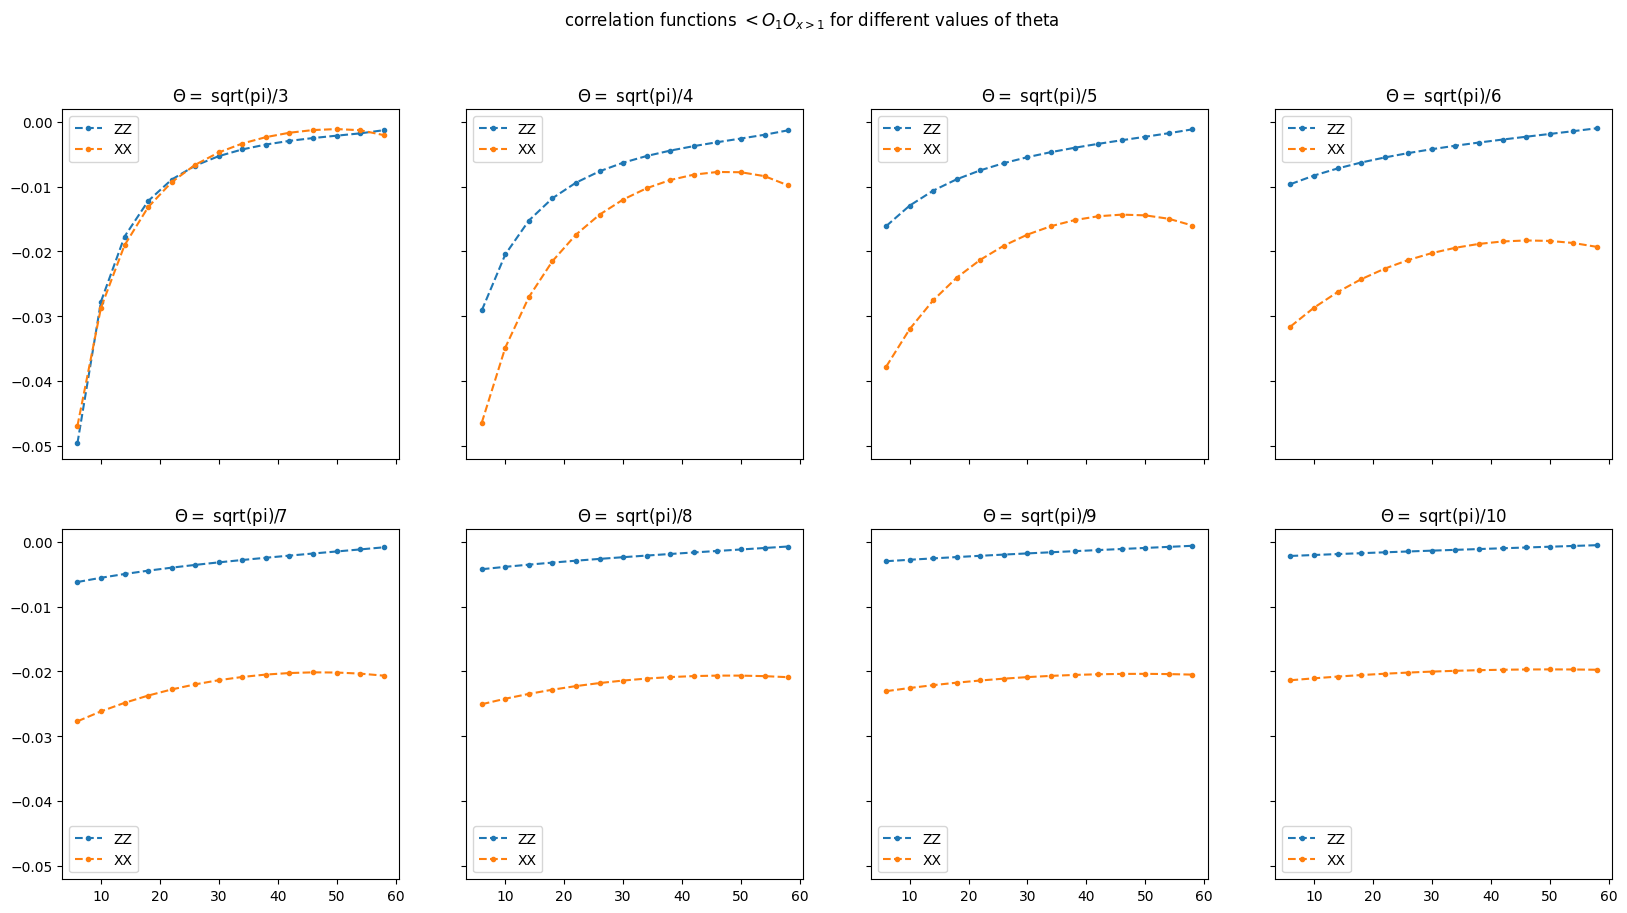

In [22]:
fig, axs = plt.subplots(2,4, figsize = (20,10), sharex=True, sharey=True)
for x in range(4):
    for y in range(2):
        axs[y,x].plot(x_list[1:],ZZ_data_JC[theta_list[4*y+x]][1:], '.--', label = 'ZZ')
        axs[y,x].plot(x_list[1:], XX_data_JC[theta_list[4*y+x]][1:], '.--', label = 'XX')
        #axs[y,x].plot(ZZ_data_motz[1,2:], '.--', label = 'ZZ motz')
        #axs[y,x].plot(XX_data_motz[1,2:], '.--', label = 'XX motz')
        axs[y,x].set_title(f'$\Theta =$ {theta_sym_list[4*y+x]}')
        axs[y,x].legend()


fig.suptitle('correlation functions $<O_1 O_{x>1}$ for different values of theta')
plt.show()

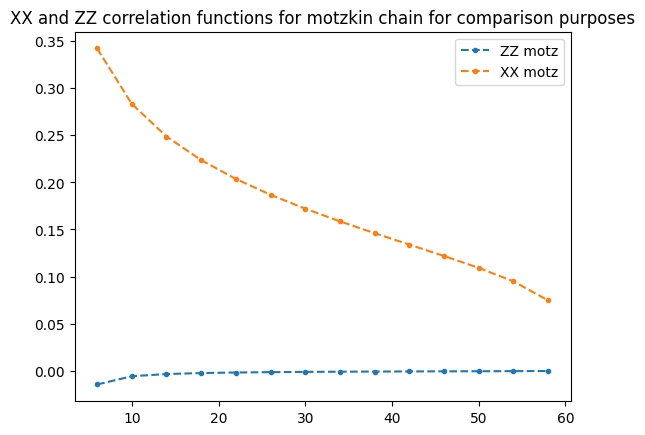

In [24]:
plt.plot(x_list[1:],ZZ_data_motz[1:], '.--', label = 'ZZ motz')
plt.plot(x_list[1:], XX_data_motz[1:], '.--', label = 'XX motz')
plt.legend()
plt.title('XX and ZZ correlation functions for motzkin chain for comparison purposes')
plt.show()

# $S_E$ array for each theta

In [6]:
t0 = time.time()

x_list = list(range(2,N,4))

SE_data_JC = {}

for theta in theta_list:
    SE_array = np.zeros(len(x_list))
    for i, x in enumerate(x_list):
        SE_array[i] = MPS_dictionary_theta[theta].entropy(x)

    SE_data_JC[theta] = SE_array

SE_motz = np.zeros(len(x_list))
for i in range(len(x_list)):
    SE_motz[i] = Motz_MPS.entropy(x_list[i])

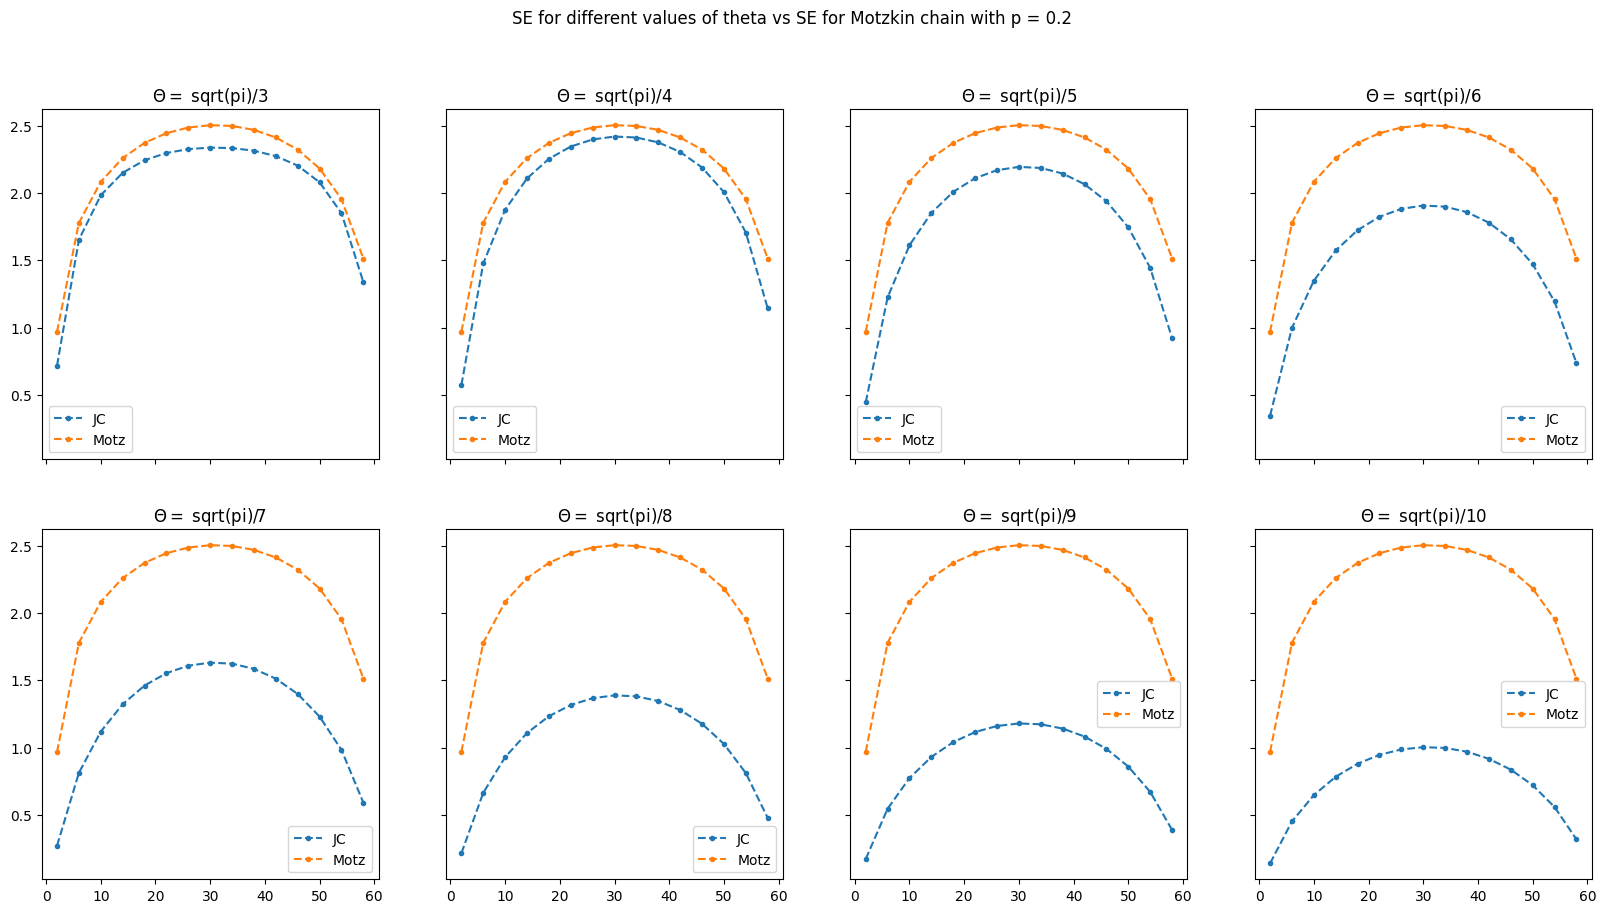

In [7]:
fig, axs = plt.subplots(2,4, figsize = (20,10), sharex=True, sharey=True)
for x in range(4):
    for y in range(2):
        axs[y,x].plot(x_list,SE_data_JC[theta_list[4*y+x]], '.--', label = 'JC')
        axs[y,x].plot(x_list,SE_motz, '.--', label = 'Motz')
        axs[y,x].set_title(f'$\Theta =$ {theta_sym_list[4*y+x]}')
        axs[y,x].legend()


fig.suptitle(f'SE for different values of theta vs SE for Motzkin chain with p = {pL}')
plt.show()